# Self preserving PSD in batch crystallization.
10.1002/aic.690420708

In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

C:\Users\wuyua\Projects\PycharmProjects\crm


In [2]:
from crm.base.system_spec import SystemSpec, ParametricFormSpec, FormSpec
from crm.jit.agglomeration import ConstantAgglomeration
from crm.base.input import Input
from crm.solvers.mcsolver import MCSolverOptions, MCSolver
from crm.utils.compress import BinningCompressor

import numpy as np
from matplotlib import pyplot as plt
from crm.base.state import State
from crm.utils.pandas import StateDataFrame

In [127]:
class AgglomerationOnlyForm(FormSpec):
    def __init__(self, name: str):
        super().__init__(name, ConstantAgglomeration(6e-13, min_count=1e4))

    def solubility(self, state: State = None, polymorph_idx: int = None, t=None) -> float:
        return 1


system_spec = SystemSpec("agg only system")
system_spec.forms = [
    AgglomerationOnlyForm("agg only form")
]


In [182]:
N0 = 1e11
L0 = 1.5e-6

L_range = np.linspace(0.1e-6, 6e-6, 100)
z = L_range / L0
n = N0 * z ** 2 / L0 * (np.exp(-z**3))

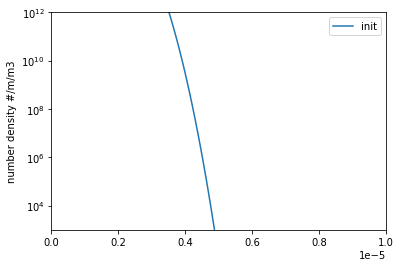

In [183]:
fig, ax = plt.subplots()
ax.plot(L_range, n)
ax.set_yscale("log")
ax.set_xlim([0, 10e-6])
ax.set_ylabel("number density #/m/m3")
ax.set_ylim([1e3, 1e12])
ax.legend(["init"])

total = 3.33305E+10


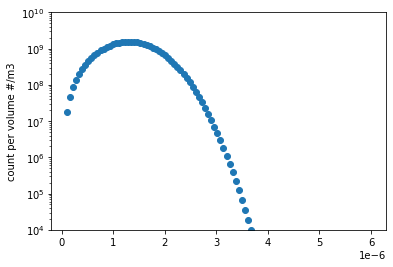

In [185]:
# convert to count per volume
N = n * (L_range[1] - L_range[0])
fig, ax = plt.subplots()
ax.scatter(L_range, N)
ax.set_yscale("log")
ax.set_ylabel("count per volume #/m3")
ax.set_ylim([1e4, 1e10])
print(f"total = {N.sum():.5E}")

In [186]:
n_init = np.vstack([L_range, N]).T
n_init = n_init[n_init[:, -1] > 1e4]
init_state = system_spec.make_state(n = [n_init])
input_ = Input()
solver_options = MCSolverOptions(time_step=1, compressor=BinningCompressor(0.1e-6))
solver = MCSolver(system_spec, solver_options)

In [187]:
results = solver.compute(init_state, 320, input_)


In [188]:
sdf = StateDataFrame(results)

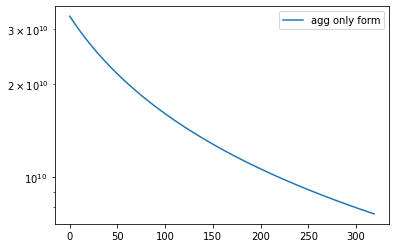

In [189]:
sdf.counts.plot()
plt.yscale("log")

<AxesSubplot:>

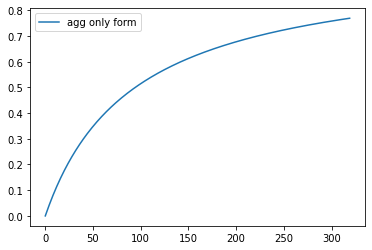

In [190]:
# I_agg

I_agg = 1 - sdf.counts / sdf.counts.iloc[0, 0]
I_agg.plot()

In [191]:
t = 300
print(f"I_agg = {1 - sdf.counts.iloc[t, 0] / sdf.counts.iloc[0, 0]}")
n_final = sdf.n.iloc[t, 0]
n_init = sdf.n.iloc[0, 0]

I_agg = 0.7578151165503021


In [192]:
kdes = sdf.get_kde()
kde_final, _ = kdes.iloc[t, 0]
kde_init, _ = kdes.iloc[0, 0]

Text(0.5, 0, 'L(m)')

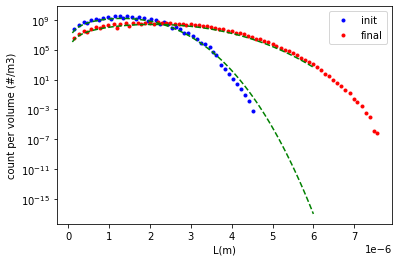

In [195]:
fig, ax = plt.subplots()
cnts = sdf.counts
ax.plot(n_init[:, 0], n_init[:, -1], ".b")
ax.plot(n_final[:, 0], n_final[:, -1], ".r")

ax.plot(L_range, n * (L_range[1] - L_range[0]), "--g")
Y=6
n_ana = 4 * N0 * z ** 2 / (L0 * (Y + 2) ** 2) * np.exp(-2*z**3/(Y+2))
ax.plot(L_range, n_ana * (L_range[1] - L_range[0]), "--g")

ax.set_yscale("log")
ax.legend(["init", "final"])
ax.set_ylabel("count per volume (#/m3)")
ax.set_xlabel("L(m)")

